Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [147]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# !unzip "CNN_assignment.zip"



Archive:  CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [138]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")


In [139]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [140]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [141]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
seed = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [142]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [143]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

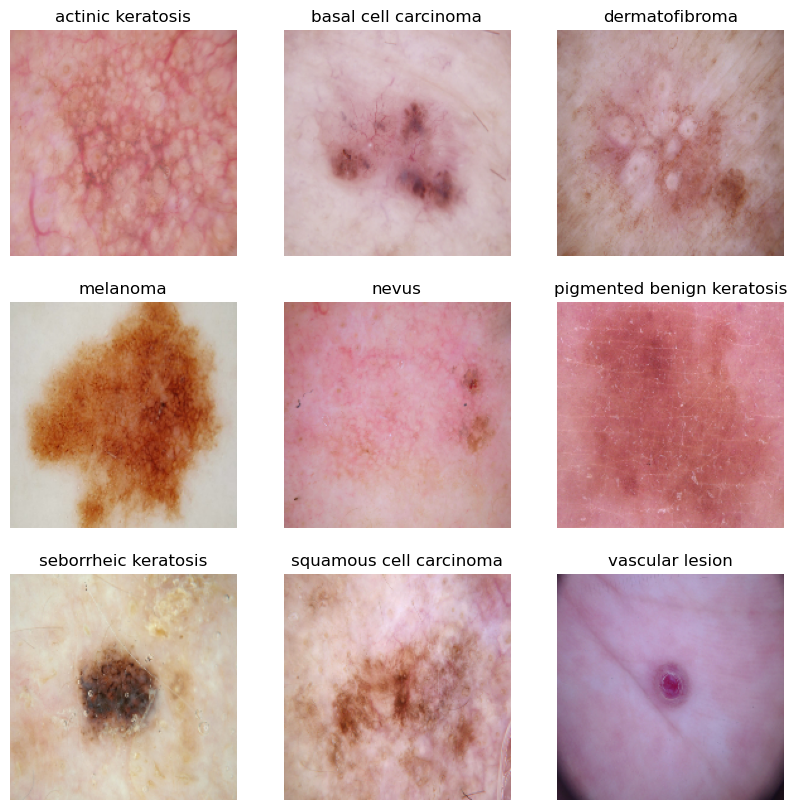

In [9]:
import matplotlib.pyplot as plt

# Initialize a dictionary to hold one instance of each class
instances = {class_name: None for class_name in class_names}

# Iterate through the dataset and collect one instance of each class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if instances[class_name] is None:
            instances[class_name] = img
        # Check if we have collected all classes
        if all(instance is not None for instance in instances.values()):
            break
    if all(instance is not None for instance in instances.values()):
        break

# Visualize the collected instances
plt.figure(figsize=(10, 10))
for i, (class_name, img) in enumerate(instances.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Build the CNN model
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes in the dataset
])


### Compile the model
Choose an appropriate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-07-17 09:07:29.039608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/56 [===========================>..] - ETA: 0s - loss: 2.1632 - accuracy: 0.2494

2024-07-17 09:07:35.180003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 7s 46ms/step - loss: 2.1510 - accuracy: 0.2573 - val_loss: 1.8177 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7299 - accuracy: 0.3856 - val_loss: 1.6892 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5038 - accuracy: 0.4777 - val_loss: 1.8236 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4455 - accuracy: 0.4933 - val_loss: 1.4988 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5411 - accuracy: 0.4598 - val_loss: 1.4859 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5262 - accuracy: 0.4760 - val_loss: 1.5337 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3679 - accuracy: 0.5073 - val_loss: 1.6829 - val_accuracy: 0.4430
Epoch 8/20
56/56 [======

### Visualizing training results

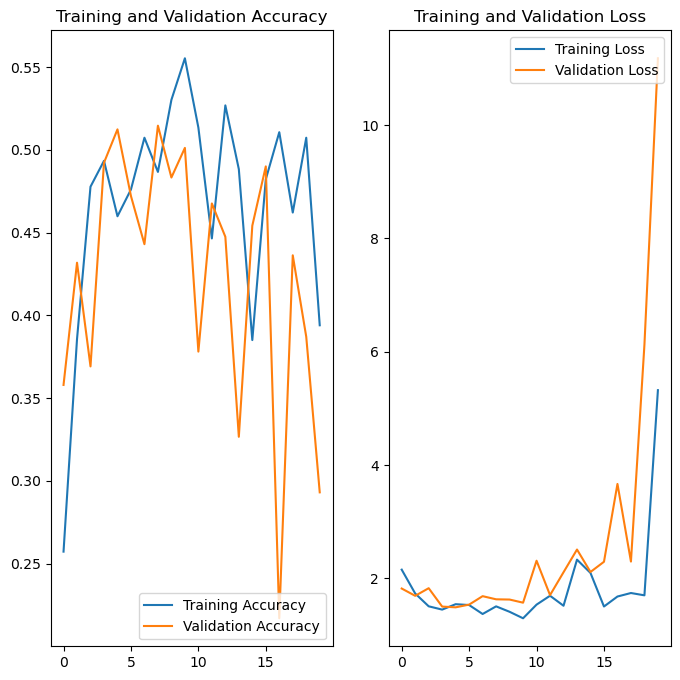

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Based on the training log, there is evidence of model overfitting:

- The validation loss increases over epochs, indicating the model's inability to generalize to new data.
- The validation accuracy does not show consistent improvement, further suggesting overfitting.

In [107]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


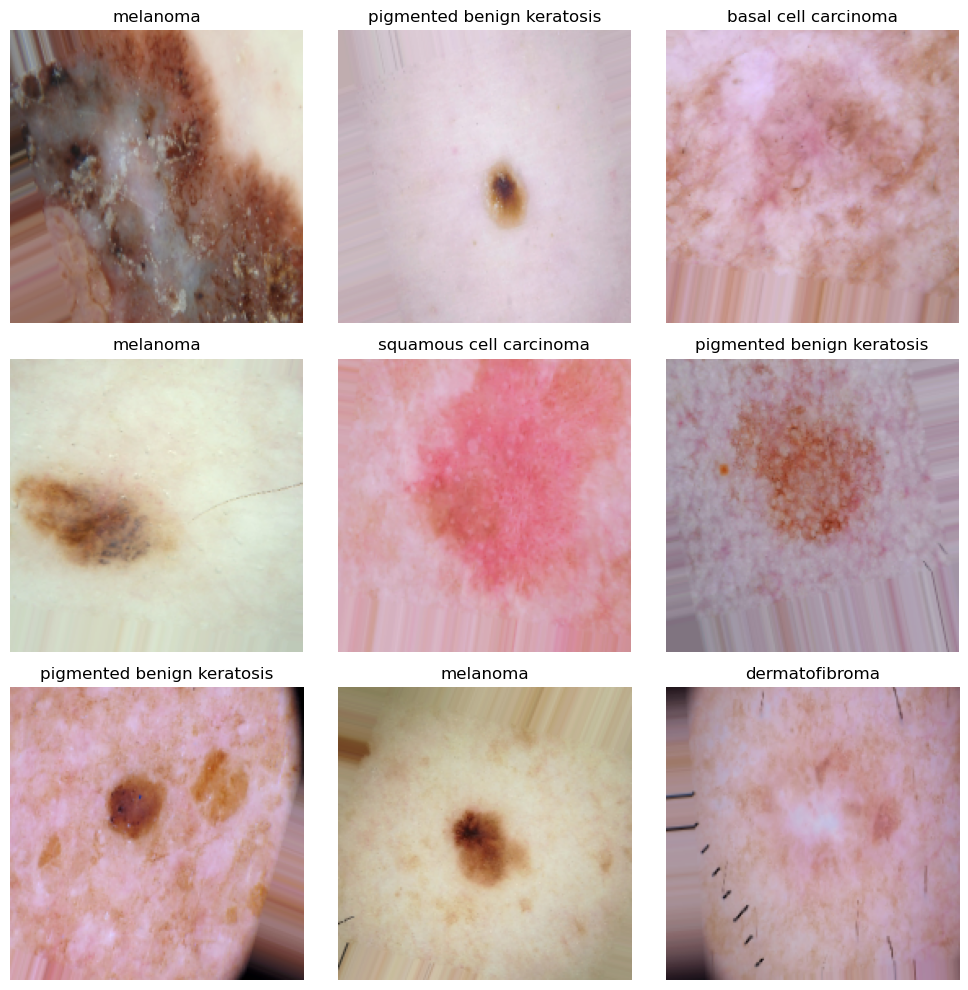

In [109]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here


# Create the training dataset
train_datagen = datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    seed=123
)

# Create the validation dataset
validation_datagen = datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    seed=123
)


# Function to visualize augmented images with class names
def visualize_augmentation(datagen):
    class_names = list(datagen.class_indices.keys())
    x, y = next(datagen)
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(x[i].astype('uint8'))
        class_idx = int(y[i])
        class_name = class_names[class_idx]
        ax.set_title(class_name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the augmentations on a batch of images
visualize_augmentation(train_datagen)




### Todo:
### Create the model, compile and train the model


In [110]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(9, activation='softmax')
])




### Compiling the model

In [111]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              

### Training the model

In [112]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20

history = model.fit(
  train_datagen,
  validation_data=validation_datagen,
  epochs=epochs
)

Epoch 1/20


2024-07-17 21:14:29.526031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 2.9047 - accuracy: 0.3465

2024-07-17 21:14:43.496944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 18s 292ms/step - loss: 2.9047 - accuracy: 0.3465 - val_loss: 2.7668 - val_accuracy: 0.2342
Epoch 2/20
57/57 [==============================] - 15s 265ms/step - loss: 2.4236 - accuracy: 0.4150 - val_loss: 3.1497 - val_accuracy: 0.2005
Epoch 3/20
57/57 [==============================] - 16s 277ms/step - loss: 2.2612 - accuracy: 0.4529 - val_loss: 2.7106 - val_accuracy: 0.1982
Epoch 4/20
57/57 [==============================] - 16s 279ms/step - loss: 2.2360 - accuracy: 0.4490 - val_loss: 4.3346 - val_accuracy: 0.2117
Epoch 5/20
57/57 [==============================] - 15s 271ms/step - loss: 2.1134 - accuracy: 0.4574 - val_loss: 3.3356 - val_accuracy: 0.2230
Epoch 6/20
57/57 [==============================] - 16s 275ms/step - loss: 2.0434 - accuracy: 0.4646 - val_loss: 2.3647 - val_accuracy: 0.2410
Epoch 7/20
57/57 [==============================] - 16s 274ms/step - loss: 2.0157 - accuracy: 0.4702 - val_loss: 2.1354 - val_accuracy: 0.4234
Epoch 8/20

### Visualizing the results

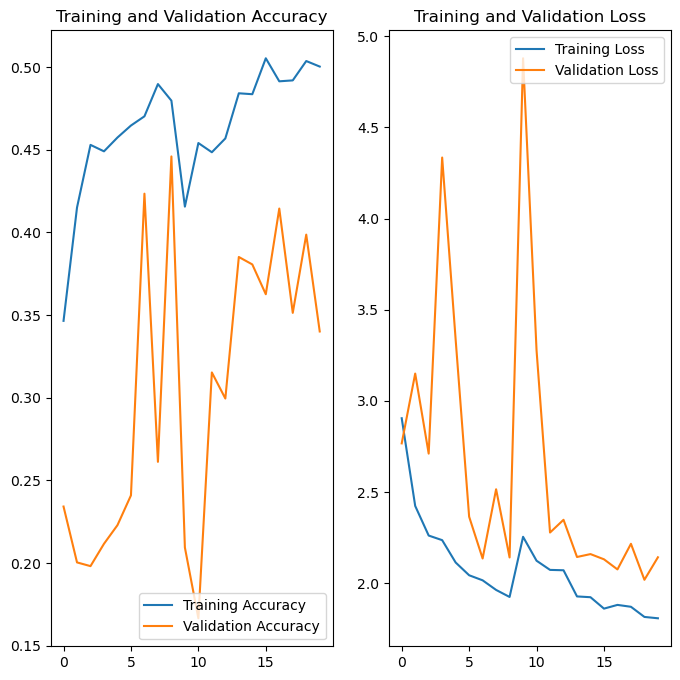

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observations:
Training Accuracy:

Starts around 34.65% in the first epoch and increases to around 50.03% by the 20th epoch.
The increasing trend in training accuracy suggests that the model is learning to classify the training data better over epochs.
Validation Accuracy:

Starts lower than training accuracy (around 23.42%) and fluctuates between 16.67% and 44.59% across epochs.
The lower validation accuracy compared to training accuracy indicates that the model may not generalize well to unseen data. It suggests potential overfitting, especially when validation accuracy is significantly lower than training accuracy.
Training Loss:

Decreases from 2.9047 to 1.8075, indicating that the model is improving its predictions on the training data over epochs.
Validation Loss:

Fluctuates, starting from 2.7668 and varying up to 4.8789, with a final value of 2.1420.
The fluctuating validation loss and higher values suggest that the model is not performing consistently well on the validation set, indicating potential overfitting or lack of generalization.
Conclusion:
Overfitting: The model is showing signs of overfitting, as evidenced by:
Higher training accuracy compared to validation accuracy.
Fluctuating and higher validation loss compared to training loss.
The gap between training and validation accuracy widening over epochs.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

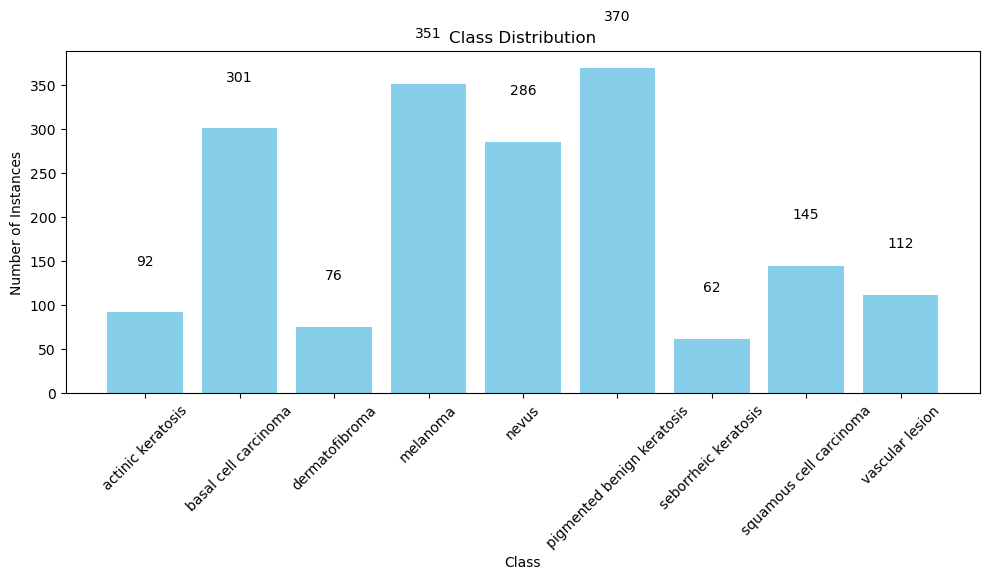

Training class counts: Counter({5: 370, 3: 351, 1: 301, 4: 286, 7: 145, 8: 112, 0: 92, 2: 76, 6: 62})


In [131]:
from collections import Counter


# Check for class imbalance
def check_class_imbalance(datagen):
    counter = Counter(datagen.classes)
    class_names = list(datagen.class_indices.keys())
    
    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, [counter[i] for i in range(len(class_names))], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    
    # Add labels to each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return counter

# Check class imbalance in training data
train_class_counts = check_class_imbalance(train_datagen)


print("Training class counts:", train_class_counts)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [132]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [134]:
class_names


0

In [144]:
path_to_training_dataset='Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x421171E80>: 100%|██████████| 500/500 [00:01<00:00, 444.32 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D391CFD0>: 100%|██████████| 500/500 [00:01<00:00, 433.07 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D4CBDEB0>: 100%|██████████| 500/500 [00:01<00:00, 432.39 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x48B42A940>: 100%|██████████| 500/500 [00:04<00:00, 107.60 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x3AB5C1CA0>: 100%|██████████| 500/500 [00:04<00:00, 117.81 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x4C8BB3460>: 100%|██████████| 500/500 [00:01<00:00, 391.13 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2E8ABF7C0>: 100%|██████████| 500/500 [00:02<00:00, 208.03 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x421153C10>: 100%|██████████| 500/500 [00:01<00:00, 408.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x330748CD0>: 100%|██████████| 500/500 [00:01<00:00, 425.46 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [145]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [149]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010366.jpg_7aafc35d-fb1c-4f1b-b866-a58df462baad.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000303.jpg_eb16ca8a-309b-4f96-bd8a-c15e25dd44b9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010942.jpg_0286e160-f6e1-4252-97e8-7a9eff2d75c9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010313.jpg_bd4202e5-d421-44b6-96de-618c7c1b6ecb.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_0c6a280b-4b73-4d73-88fe-b3fe77f292a3.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010723.jpg_05dc1400-e69c-4994-8d8d-dc09e1d65747.jpg',
 'Skin cancer IS

In [151]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [153]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [158]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2


In [159]:
new_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4496,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4497,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4498,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


In [160]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [161]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [163]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [164]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [165]:
## your code goes here
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [166]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [167]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=validation_datagen,
  epochs=epochs
)

Epoch 1/30


2024-07-17 22:29:52.303340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - ETA: 0s - loss: 2.6454 - accuracy: 0.3507

2024-07-17 22:30:03.674912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 15s 84ms/step - loss: 2.6454 - accuracy: 0.3507 - val_loss: 2.8036 - val_accuracy: 0.1486
Epoch 2/30
169/169 [==============================] - 12s 69ms/step - loss: 2.1038 - accuracy: 0.4412 - val_loss: 2.2429 - val_accuracy: 0.4189
Epoch 3/30
169/169 [==============================] - 12s 68ms/step - loss: 1.9013 - accuracy: 0.5030 - val_loss: 2.5206 - val_accuracy: 0.2005
Epoch 4/30
169/169 [==============================] - 12s 69ms/step - loss: 1.8112 - accuracy: 0.5341 - val_loss: 2.5535 - val_accuracy: 0.1959
Epoch 5/30
169/169 [==============================] - 12s 68ms/step - loss: 1.7617 - accuracy: 0.5681 - val_loss: 2.1412 - val_accuracy: 0.4842
Epoch 6/30
169/169 [==============================] - 12s 70ms/step - loss: 1.7106 - accuracy: 0.6057 - val_loss: 2.5534 - val_accuracy: 0.2905
Epoch 7/30
169/169 [==============================] - 12s 68ms/step - loss: 1.6490 - accuracy: 0.6606 - val_loss: 2.3976 - val_accuracy: 0.4369
Epo

#### **Todo:**  Visualize the model results

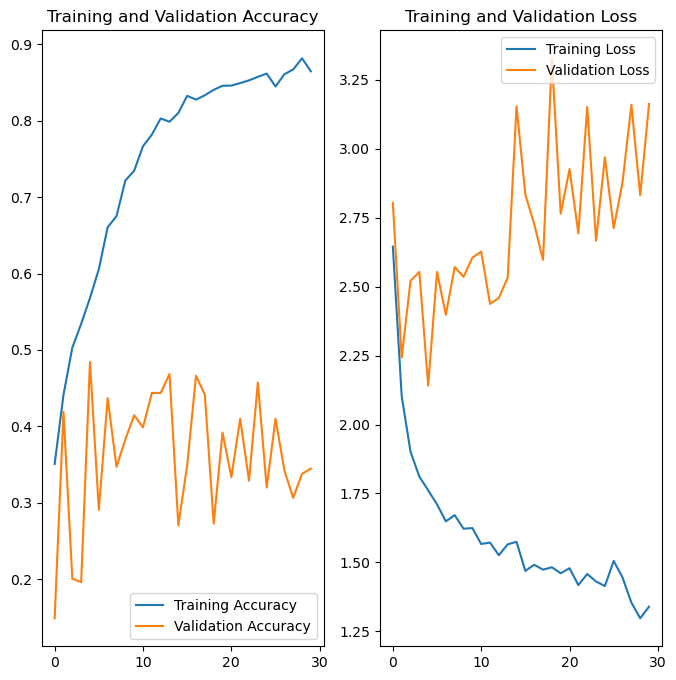

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Training accuracy increased but model is still overfitting as validation accuracy is way less than the training accuracy